# 最適腕識別_実装
- 「バンディット問題の理論とアルゴリズム」の6章(最適腕識別とA/Bテスト)のアルゴリズムを実装。
- とりあえず関数の部分を外出し。（gitでレビューしやすくするため）

## 前準備

In [1]:
import warnings
warnings.simplefilter('ignore')

import os
os.chdir('../')

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lib import best_arm_policies as bp
from lib.arms import NormalArm

In [2]:
# armのオブジェクト生成。
arm1 = NormalArm('arm1', 3.0, 1.0)  # X1 ~ N(μ1, σ1)
arm2 = NormalArm('arm2', 10.0, 1.0)  # X2 ~ N(μ2, σ2)
arm3 = NormalArm('arm3', 10.1, 1.0)  # X3 ~ N(μ3, σ3)
arm4 = NormalArm('arm4', 10.15, 1.0)  # X3 ~ N(μ4, σ4)

In [3]:
# arm動作テスト_1: 各アームから報酬を1件ずつ吐き出す
reword_ = [arm1.draw(), arm2.draw(), arm3.draw()]
print(reword_)

[2.9081377207036962, 10.28211884636556, 10.548090168617623]


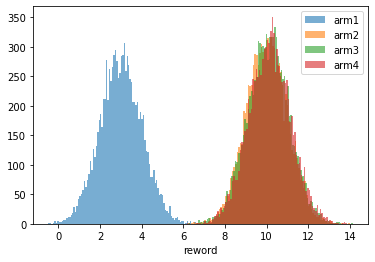

In [4]:
# arm動作テスト_2: 各アームをx回ずつ引いて報酬の分布を描画
iter_ = 10000
reword_1 = [arm1.draw() for i in range(0,iter_)]
reword_2 = [arm2.draw() for i in range(0,iter_)]
reword_3 = [arm3.draw() for i in range(0,iter_)]
reword_4 = [arm4.draw() for i in range(0,iter_)]

# 描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(reword_1, bins=100, alpha=0.6)
ax.hist(reword_2, bins=100, alpha=0.6)
ax.hist(reword_3, bins=100, alpha=0.6)
ax.hist(reword_4, bins=100, alpha=0.6)

ax.set_xlabel('reword')
ax.legend(['arm1', 'arm2', 'arm3', 'arm4'])
plt.show()

### アルゴリズム6.1: 逐次削除方策(successive elimination policy)
- 最適腕である可能性が残っているアームを一様に選択していく方式。
- 教科書p.104 アルゴリズム6.1に従って実装。

In [5]:
# 実行
target_arms = [arm1, arm2, arm3, arm4]
df_se = bp.successive_elimination_policy(target_arms, 0.04, 0.01, 10000)

3601, {'name': 'arm4', 'mu': 10.15, 'sigma': 1.0}
[   1 3344 3601 3601]
finish


In [6]:
df_se.head()

,best_arm,arm1_mean,arm2_mean,arm3_mean,arm4_mean,arm1_ucb,arm2_ucb,arm3_ucb,arm4_ucb,arm1_lcb,arm2_lcb,arm3_lcb,arm4_lcb
0,arm2,3.102864,11.216025,9.533207,11.045290,5.02351,13.136671,11.453852,12.965935,1.182219,9.295380,7.612561,9.124644
1,arm2,NaN,10.430688,10.372832,10.373980,NaN,11.910895,11.853039,11.854187,NaN,8.950481,8.892625,8.893773
2,arm4,NaN,10.096100,10.252353,11.080229,NaN,11.359362,11.515615,12.343491,NaN,8.832838,8.989091,9.816967
3,arm4,NaN,9.857349,9.830916,11.048575,NaN,10.983756,10.957323,12.174982,NaN,8.730941,8.704508,9.922167
4,arm4,NaN,9.861672,9.744876,10.943146,NaN,10.891071,10.774276,11.972545,NaN,8.832272,8.715477,9.913746


### アルゴリズム6.2: LUCB方策(LUCB policy)
- 最適腕の推定に役立つアームを適応的に選択する方策(の１つ)
- 探索終了条件は逐次削除方策と同じ。
- 探索継続時に、最適腕(最新)の下限とそれ以外のアームの期待値の上限の差が広がるように、それぞれアームを引く。
  - 分かりにくいが、以下２つを比較して終了/継続を決めるということか。
    - 最適腕(最新)の下限: 最適腕i*のLCB
    - それ以外のアームの期待値の上限: 最適腕以外のアームでUCBが最も大きいアームi**、のUCB
- 教科書p.107, アルゴリズム6.2に従って実装。

In [7]:
# 実行
target_arms = [arm1, arm2, arm3, arm4]
df_lucb = bp.lucb_policy(arms_=target_arms, 
                      epsilon=0.04, 
                      delta=0.01, 
                      max_iter=50000)

19199, {'name': 'arm4', 'mu': 10.15, 'sigma': 1.0}
[   1 1822 7914 9465]
finish


In [8]:
df_lucb.head()

,best_arm,next_pull_arm,arm1_mean,arm2_mean,arm3_mean,arm4_mean,arm1_ucb,arm2_ucb,arm3_ucb,arm4_ucb,arm1_lcb,arm2_lcb,arm3_lcb,arm4_lcb
0,arm3,arm2,3.786342,9.608328,10.203324,9.483853,5.549096,11.371082,11.966079,11.246607,2.023587,7.845573,8.440570,7.721098
1,arm2,arm3,3.786342,10.521258,10.360639,9.483853,6.089498,12.149835,11.989217,11.787009,1.483186,8.892681,8.732062,7.180697
2,arm2,arm4,3.786342,10.267610,10.191409,9.483853,6.301532,11.719756,11.643554,11.999043,1.271152,8.815465,8.739263,6.968663
3,arm2,arm4,3.786342,10.483024,10.191409,9.974543,6.431928,11.805817,11.718839,11.845255,1.140756,9.160232,8.663979,8.103831
4,arm2,arm3,3.786342,10.495289,10.191409,9.954148,6.525275,11.720177,11.772732,11.535471,1.047409,9.270401,8.610085,8.372824


## メモ
- 逐次削除、LUCB、の2方策を実装。
- ２手法の各アーム選択数をみると、以下の傾向があるっぽい。（後ほど改めて整理）
  - 両方に言えること: 期待値が大幅に低いアーム(arm1)は最初に除外している
  - 逐次選択: 期待値が少しアーム(arm2)を引く回数が少し多め。
  - LUCB: 期待値が上位かつ近いアーム(arm3,4)を引く回数が多く、最適腕を判別するのに時間がかかっている。

## 時間があればやっておきたい
- 関数化しておく: 一応Done
- 収束までの経緯を可視化してみたい(μ, 誤識別率の推移を時系列のグラフにする？): データ出力までは完了
- epsilon , deltaを変えた時の挙動変化を見たい。
  - 収束までに必要なサンプル数の分布はどのくらいか？ 上限は標本複雑度に従っているか？
  - epsilonを荒くすると、それ未満の平均値の差が区別されにくくなることは確認済み。